In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("Homework2.ipynb")

# Sentiment Analysis using Naive Bayes

In [12]:
import re
import string
import random
from collections import Counter

# pip install nltk
import nltk
import pandas as pd
import numpy as np
import sklearn
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import otter

grader = otter.Notebook()
nltk.download('stopwords')
stop_words = stopwords.words()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tage\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Part 1: Data Preprocessing

In [13]:
def clean_data(review):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    review = review.lower()

    review = emoji_pattern.sub(r'', review)   

    #Remove contractions
    review=re.sub("isn't", "is not", review)
    review=re.sub("he's", "he is", review)
    review=re.sub("what's", "what is", review)
    review=re.sub("it's", "it is", review)
    review=re.sub("couldn't", "could not", review)
    review=re.sub("wouldn't", "would not", review)
    review=re.sub("can't", "cannot", review)
    review=re.sub("we're", "we are", review)
    review=re.sub("aren't", "are not", review)
    review=re.sub("i'm", "i am", review)
    review=re.sub("you're", "you are", review)
    review=re.sub("she's", "she is", review)
    review=re.sub("wasn't", "was not", review)
    review=re.sub("they're", "they are", review)
    review=re.sub("hasn't", "has not", review)
    review=re.sub("that's", "that is", review)
    review=re.sub("here's", "here is", review)
    review=re.sub("who's", "who is", review)
    review=re.sub("there's", "there is", review)
    review=re.sub("weren't", "were not", review)
    review=re.sub("haven't", "have not", review)
    review=re.sub("don't", "do not", review)
    review=re.sub("hadn't", "had not", review)
    review=re.sub("won't", "will not", review)
    review=re.sub("did't", "did not", review)
    review=re.sub("doesn't", "does not", review)
    review=re.sub("shouldn't", "should not", review)

    #Remove links
    review = re.sub('https?://\S+|www\.\S+', '', review)

    #Remove non alphabetic characters
    review = re.sub(r'\n', ' ', review)
    review = re.sub(r'[^a-zA-Z\s]', '', review)

    return review

In [14]:
# read in and clean data
data = pd.read_csv("IMDB Dataset.csv")
cleaned_data = data['review'].apply(clean_data)

cleaned_data = pd.DataFrame(cleaned_data)
cleaned_data['sentiment'] = data['sentiment']

In [5]:
# remove stop words
# this will take a long time to run, likely at least 10 minutes.
cleaned_data['no_sw'] = cleaned_data['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [6]:
# find value counts of all words in all data points
counter = Counter()
for text in cleaned_data["no_sw"].values:
    for word in text.split():
        counter[word] += 1

# creates a set of the 10 most common words amongst all reviews
FREQWORDS = set([w for (w, wc) in counter.most_common(10)])

In [7]:
def remove_freqwords(text, freqwords):
    '''Given a review that has been cleaned, returns the review without the most frequently appearing words'''
    return ' '.join([word for word in text.split() if word not in (freqwords)])
        
# remove frequent words that do not add value to the model
cleaned_data["no_sw"] = cleaned_data["no_sw"].apply(lambda text: remove_freqwords(text, FREQWORDS))

In [8]:
# replace the sentiment with binary 0 or 1, prepare for model
tokenized_data = cleaned_data.drop(columns=['review'])
tokenized_data.columns = ['sentiment', 'review']

#convert the sentiment values to a binary 0 or 1
tokenized_data['sentiment'] = tokenized_data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

#complete data preprocessing by changing the review format from a string of words to a list of strings containing individual words
tokenized_data['review'] = tokenized_data['review'].apply(lambda x: x.split())

Part 2: Naive Bayes Implementation

In [9]:
class NaiveBayesModel:
    '''Class representing the implementation of the Naive Bayes model'''

    def __init__(self) -> None:
        self.occurrence_table = {}
        self.probability_table = {}
        self.labels = []

    def train_model(self, data, labels):
        '''Runs the training process for the model, building the occurrence table and probability table'''

        self.labels = list(set(labels))
        self.build_occurrence_table(data, labels)
        self.build_probability_table()

        pass

    def build_occurrence_table(self, data, labels):
        '''Private function to create the occurrence table given the training data and labels'''

        # creates a nested dictionary table of frequencies based on the training data.
        # example format for the word 'word': {'word': {0: 3, 1: 15}}

        for review, sentiment in zip(data, labels):
            for word in review:
                if word not in self.occurrence_table:
                    self.occurrence_table[word] = {0: 0, 1: 0}
                
                self.occurrence_table[word][sentiment] += 1
        
        pass

    def build_probability_table(self):
        '''Private function to create the probability table based on the occurrence table'''

        # generates a table of probabilities based on the frequencies recorded in the occurrence table
        # example format for the word 'word': {'word': {0: 0.1667, 1: 0.8333}}

        for word, sentiment_counts in self.occurrence_table.items():
            total_occurrences = sum(sentiment_counts.values())

            probabilities = {}
            for sentiment, count in sentiment_counts.items():
                probabilities[sentiment] = count / total_occurrences

            self.probability_table[word] = probabilities

        pass

    def predict(self, variables):
        '''Takes a set of variables, and predicts the class they should belong to'''

        predictions = []

        for variable in variables:
            neg_probability = self.naive_bayes(0, variable)
            pos_probability = self.naive_bayes(1, variable)

            if (neg_probability == pos_probability):
                predicted_label = random.choice([0, 1])
            else:
                predicted_label = 0 if neg_probability > pos_probability else 1

            predictions.append(predicted_label)

        return predictions
    
    def naive_bayes(self, label, variable):
        probability = self.labels.count(label) / len(self.labels)

        for word in variable:
            if word in self.probability_table:
                probability *= self.probability_table[word][label]

        return probability

In [10]:
# perform a train/test split on the data
X=tokenized_data['review']
y=tokenized_data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=30)

# train and predict using the Naive Bayes model implementation
nb_model = NaiveBayesModel()
nb_model.train_model(X_train, y_train)
pred = nb_model.predict(X_test)
print(pred)

[1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 

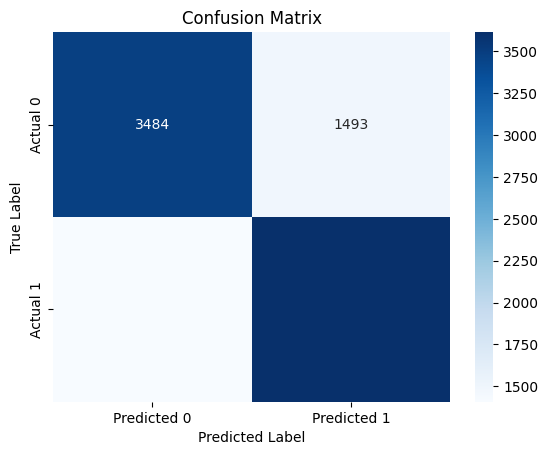

Accuracy:  0.7099
Precision:  0.7077133907595928
Recall:  0.7196894286283098
F-Score:  0.7136511696772282


In [11]:
#TODO - Create and display confusion matrices and evaluation metrics to prove the performance of your model.
# required: accuracy, recall, f-score

from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

confusion_matrix = metrics.confusion_matrix(y_test, pred)

accuracy = metrics.accuracy_score(y_test, pred)
precision = metrics.precision_score(y_test, pred)
recall = metrics.recall_score(y_test, pred)
f_score = metrics.f1_score(y_test, pred)

sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F-Score: ", f_score)

## Submission Questions

**Discuss the performance of your model based on the evaluation metrics and confusion matrix that you created. Why did you choose these metrics, and what do they tell you about the performance of the model? Include the metrics and confusion matrix in your answer. Make sure to explicitly state the values of your metrics in the write up**

My model preformed alright. It had an accuracy, precision, recall, and f-score that were all roughly 0.71 or 0.72. This shows that the model was decently accurate at prediction whether or not a given review had a positive or negative sentiment. I used those four metrics because we had talked about them in class, and they are useful metrics for determining how well a model gave back what was desired. Obviously precision is a measure of how much of the positive responses were actually positive, which is useful, and recall determines how much of the responses that were indeed positive came back as positive. The F-score is a combination, and all 4 metrics together do a good job of showing how accurate the model was. In this case, that was moderately accurate.

**Explain how you interpret the output of your model. If you worked at IMDB, would the output of your model be useful? How might the interpretability of the model be improved?**

Yes, I believe it would be fairly useful. I think the metrics that are printed out, as well as the graph of the confusion matrix gives a good indication of how well the model did at predicting when a certain piece of feedback was negative or positive.

**Do you believe the Naive Bayes model is suitable for this type of analysis? Why or why not?**

Probably not, given that I don't think that every word/review can really be considered as independent from one another. The indepence assumption here probably just isn't a good assumption to make, so maybe using a machine learning model that doesn't assume independence would be more helpful.

**If you made any enhancements or included any additional operation to your implementation, feel free to mention that here!**

I didn't do any data cleaning or other enhancement to my implementation.

**What did you find the most challenging about the implementation of Naive Bayes for sentiment analysis? Was there anything that surprised or interested you?** 

I think for me, the hardest parts were, one, actually trying to understand the underlying math behind the Naive Bayes model, as I still didn't really understand it until having to do this assignment, and also just manipulating the data structures that were in this assignment. A lot of the time, I knew what I wanted to do, but I didn't really know what was stored where, and it took me a bit to understand how all the data was being represented.